# For Full Write Up: https://medium.com/@bpunt/drake-using-natural-language-processing-to-understand-his-lyrics-fe6edf90bf

In [1]:
#Importing Dependecies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from os import path
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.tag.stanford import StanfordNERTagger
import string
from nltk.corpus import stopwords
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.manifold import TSNE
from PIL import Image
import pyLDAvis 
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline

### Before jumping into actual analysis, I had get my hands on Drake's Lyrics. Although there are several resources online to extract his lyrics, I decided to use Genius.com. Genius has a wonderful API, that is beautiful simple and easy to use. All you have to do is acquire a key and Genius makes it exceptionally simple to get lyrics.

### Analysis 1:
### Which Drake Song has the most unique words?
### One of the things that Drake often gets criticized over is his creativity- or lack thereof. In the past he has been accused of stealing other rapper's flows (https://uproxx.com/hiphop/drake-biting-style-more-life/) and having ghost writers (see Meek Mill Drake Beef) among other things. I set out to see out to see if his critics complaints were correct. 
### The inspiration to use number of unique word per song was from this beautiful article that visualized the largest vocabularies in rap (https://pudding.cool/2017/02/vocabulary/).  In my opinion, total words is a much worse measure of creativity due to the repetitiveness of today's artists. Although not necessarily a bad thing, it has definitely a pheonomenon https://pudding.cool/2017/05/song-repetition/

### Cleaning

### In order to actually analyze every song, I had to clean up the text data. The cleaning process included normalizing (lower-casing), tokenizing (breaking up sentences into words) and removing punctuation. Once I did this, I removed stopwords. In English, Stopwords are those that are "extremely common words which would appear to be of little value in helping select documents matching a user need" (https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html). Words such as "and" and "the" are among the most common stopwords but there are others. To aid with the cleaning process, I used NLTK (Natural Language Tool Kit) a popular Python Library for working with text data. 

In [2]:
Drake=pd.read_json("Lyrics_Drake.json")

In [3]:
def get_album(song_dict):
    """Input Column of df. Replaces Non-album song releases with description 'single."""
    album=song_dict["album"]
    if album==None:
        return "Single"
    else:
        return album


In [4]:
def creating_columns(df):
    """Creating a column that give name of album and song title for each row."""
    df["Album"]=df.songs.apply(func=lambda song:get_album(song))
    df["title"]=df.songs.apply(func=lambda song:song["title"])
    return df

In [5]:
Drake=creating_columns(Drake)

In [6]:
#Adding common stopwords
stopword=set(stopwords.words('english'))
words=["thats","yeah","i'm","got","get","niggas","nigga"]
for x in words:
    stopword.add(x)

In [7]:
def clean_it(p):
    """ This function takes in a dataframe. It cleans up all of the lyrics for that dataframe.
    It returns a dictionary where keys are titles for songs and keys are a list of original lyrics"""
    final={}
    for number in range(len(p)):
        example_text=p["songs"][number]["lyrics"]
        clean_text=example_text.replace("\n"," ")
        clean_text=re.sub('\[(.*?)\]',"",clean_text)
        list_it=clean_text.split(" ")
        list_words = [word for word in list_it if x != ""]
        lower_words=[str.lower(x) for x in list_words]
        new_term_vector=[]
        for word in lower_words:
            if not word in stopword:
                new_term_vector.append(word)
        
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        new_review = []
        for token in new_term_vector: 
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                new_review.append(new_token)
        final[p["songs"][number]["title"]]=new_review
    return final

In [8]:
cleaned=clean_it(Drake)

In [9]:
def populate_df(input_dict):
    """Populating an empty dataframe with cleaned up lyrics"""
    df = pd.DataFrame()
    for items in input_dict.items():
        df2=pd.DataFrame([items])
        df=df.append(df2)
    df.rename(columns={0:"title",1:"Lyrics"},inplace=True)
    return df

In [10]:
df=populate_df(cleaned)

In [11]:
def lyric_calculations(df):
    """ Creating columns for basic lyrical calculations."""
    df["Lyrics_Counted"]=df.Lyrics.apply(func=lambda x: Counter(x))
    df["total_words"]=df.Lyrics_Counted.apply(func=lambda x: len(x.keys()))
    sorted_Lyrics=df.sort_values(by="total_words",ascending=False)
    return sorted_Lyrics

In [12]:
sorted_Lyrics=lyric_calculations(df)

In [13]:
Merged=sorted_Lyrics.merge(Drake[["title","Album"]],on="title",how="inner")

In [14]:
#Writing File to CSV so I can use Tableau
Merged.to_csv("Drake.csv")

### Once I was finished with cleaning the text data, I could thehn begin analyzing the unique number of lyrics in every song. Below is a histogram of the distribution of unique lyrics in All Drakes songs. It seems that the majority of his songs have between 100 and 200 unique words.

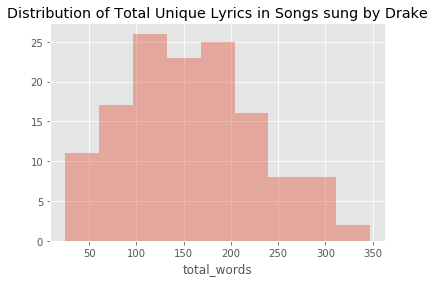

In [15]:
#Histogram Distribution of Total Unique Lyrics with all songs
ax=sns.distplot(Merged.total_words,kde=False)
ax.set_title("Distribution of Total Unique Lyrics in Songs sung by Drake")

### These ten songs contain the most unique lyrics. Every album is represented on this list. Shows what is shown on the graph.

In [16]:
Merged.sort_values(by="total_words",ascending=False)[["title","Album"]][:10]

,title,Album
0,6PM in New York,If You're Reading This It's Too Late
1,Sacrifices,More Life
2,Lord Knows,Take Care
3,Tuscan Leather,Nothing Was the Same
4,All Me,Nothing Was the Same
5,Diplomatic Immunity,Scary Hours
6,Weston Road Flows,Views
7,"Two Birds, One Stone",Single
9,Miss Me,Thank Me Later
8,Used To,If You're Reading This It's Too Late


### Without a reference to the distribution of other artists, this histogram does not tell me much about Drake's Creativity. 
### A better way to plot my findings was by album. The plot, pictured below, was created in Tableau. On the X-Axis is the name of the work. The Y- Axis is the number of unique words. Each Bubble represents a song. No album seems to be much more creative (in terms of unique lyrics), however, it seems that every work has at least one outlier in terms of number of unique lyrics (minus Scorpion). It is kind of fascinating to see that songs on Scorpion, his most recent release, have little variation in number of unique lyrics despite being such a massive album (over 25 songs).

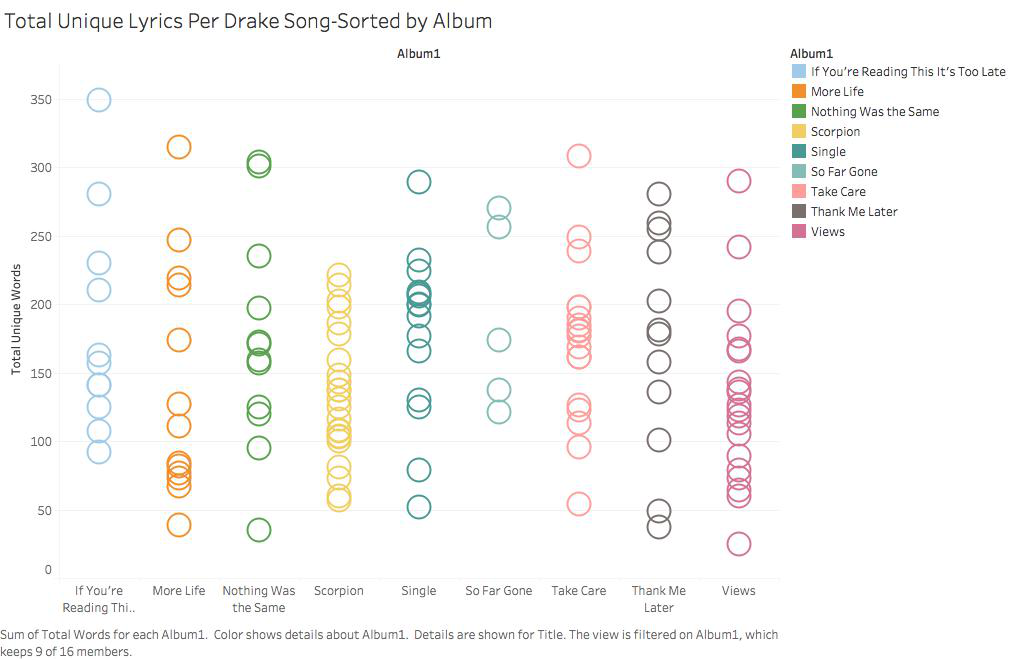

In [17]:
#Plotting Unique Lyrics in all songs on every album
Image.open("/Users/barbarapunturo/Documents/Drake_Lyrics.jpg")

### Part II 

### Named Entity Recognition

### Named Entity Recognition is "a subtask of information extraction that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc." (wikipedia). NER is a particularly tricky task in the world of NLP. The complexity of the human language makes it very difficult to created a NER algorithm that is accurate. As a result, there have been multiple attempts at NER algorithms.

### An algorithm may peform very well on one corpora of text, and then perform poorly on another. This inconsistency makes it necessary to try out several NER algorithms. As you will see, algorithms are pretty inconsistent.

### The first one I tried was the Named Entity Algorithm provided by NLTK. "Ne_chunk" uses a list of words with Part Of Speech tags (POS tagging algorithms are complex topic on their own for more information check out:) assigned to them to infer what words are Named Entities. As you can see from the results I found, NLTK's algorithm does not do a very good job on its own. It gets some words right, others like " Will" are classified incorrectly as Named Entity Objects.

### The second Named Entity Algorithm that I tried was Stanfords. Stanford's Computational Linguistics Department is probably the best in the world. One of the multitude of impressive tools to come out of this esteemed department was their NER tool (more info can be found here). The tool takes a longer time to run, but to the tune of much more accurate results. Although it probably is not perfect, it is a massive improvement.

## Named Entity Recognition

In [18]:
def get_NE(text):
    """ Input list ofsongs. Uses NLTK built- in Named Entity Recognizer to output Named Entities
    and a dictionary of types of Named Entities"""
    POS_Count = defaultdict(int)
    count=[]
    for song in text:
        Named_Entities = ne_chunk(pos_tag(word_tokenize(song)))
        for word in Named_Entities:
            if type(word) == Tree:
                for token,pos in word.leaves():
                    count.append(token)
                    POS_Count[word.label()]+=1
    return count,POS_Count

In [19]:
def clean_itt(p):
    """ This function takes in a dataframe column. It cleans up all of the lyrics for that dataframe.
    It returns a dictionary where keys are titles for songs and keys are a list of original lyrics"""
    p=p["lyrics"]
    clean_text=p.replace("\n"," ")
    clean_text=re.sub('\[(.*?)\]',"",clean_text)
    return clean_text

In [20]:
cleaned_up_lyrics=Drake.songs.apply(func=lambda x: clean_itt(x))

In [21]:
#Using get_NE to append a list of all mentioned objects
list_things=[]
Words,Count=get_NE(cleaned_up_lyrics)

In [22]:
count=Counter(Words)
most_mentioned_ = [(k, count[k]) for k in sorted(count, key=count.get, reverse=True)]

In [23]:
tagger = StanfordNERTagger('/Users/barbarapunturo/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz',
               '/Users/barbarapunturo/stanford-ner-2018-02-27/stanford-ner.jar',
               encoding='utf-8')

In [24]:
#Finding the most named entities from Stanford's Tagger
counted=[]
POS_Count = defaultdict(int)
for lyrics in cleaned_up_lyrics:
    tagged=(tagger.tag(nltk.word_tokenize(lyrics)))
    for z in tagged:
        tag,POS=z
        if POS != "O":
            POS_Count[POS]+=1
            counted.append(tag)

In [25]:
cnt=Counter(counted)
stanford = [(k, cnt[k]) for k in sorted(cnt, key=cnt.get, reverse=True)]

In [26]:
#Elimnating Expletitives

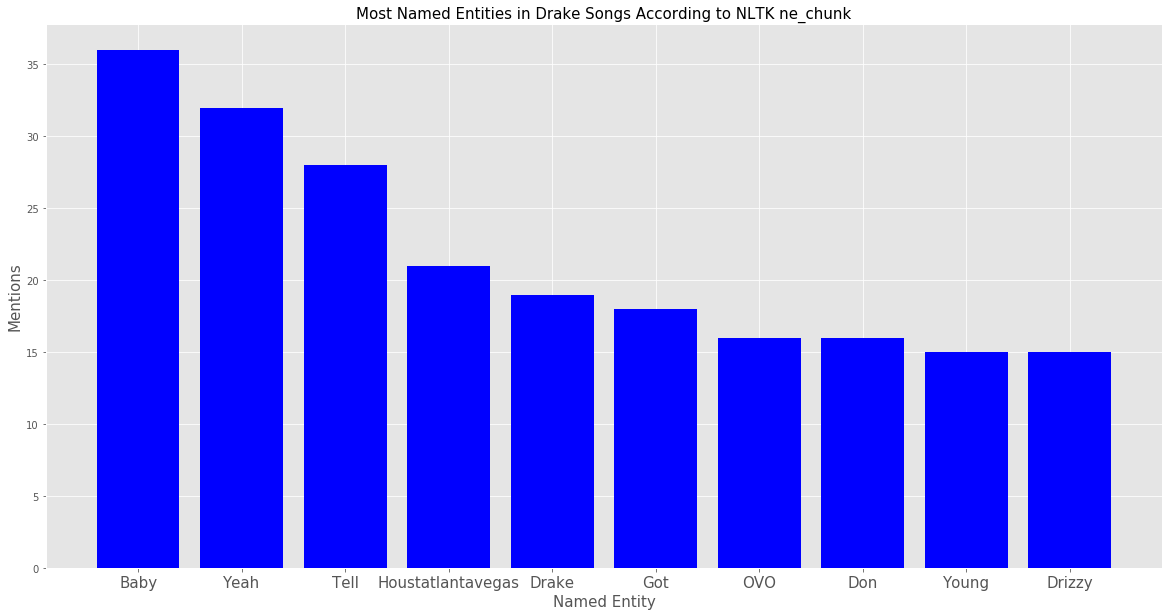

In [27]:
#This block finds the most named entities according to the chunker from NLTK
fig,ax=plt.subplots(figsize=(20,10))
ne = [ne for ne,count in most_mentioned_[:10]]
count_of =[count for ne,count in most_mentioned_[:10]]
x_pos = np.arange(len(ne)) 


plt.bar(x_pos, count_of,align='center',color="b")
plt.xticks(x_pos, ne,fontsize=15) 
plt.title("Most Named Entities in Drake Songs According to NLTK ne_chunk",fontsize=15)
plt.ylabel('Mentions',fontsize=15)
plt.xlabel("Named Entity",fontsize=15)
plt.show()

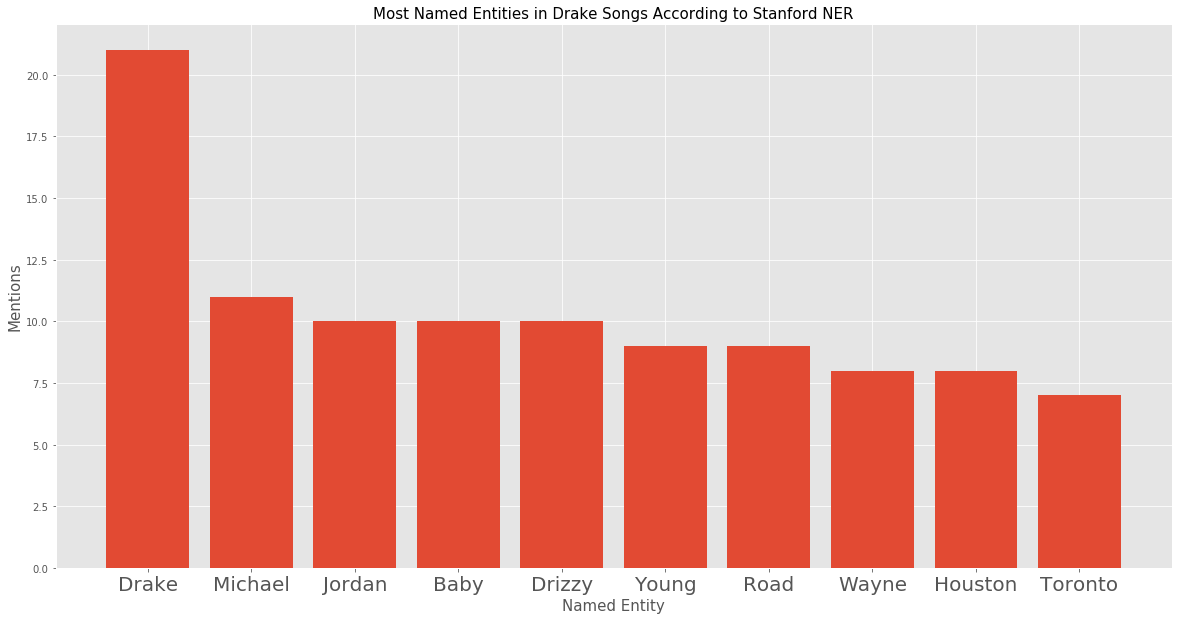

In [28]:
#This block finds the most named entities according to the chunker from Stanford
fig,ax=plt.subplots(figsize=(20,10))
ne = [ne for ne,count in stanford[:10]]
count_of =[count for ne,count in stanford[:10]]
x_pos = np.arange(len(ne)) 


plt.bar(x_pos, count_of,align='center')
plt.xticks(x_pos, ne,fontsize=20) 
plt.title("Most Named Entities in Drake Songs According to Stanford NER",fontsize=15)
plt.ylabel('Mentions',fontsize=15)
plt.xlabel("Named Entity",fontsize=15)
plt.show()

In [29]:
#This block of code calculates the differece in different Named Entities found between both algos
dic_difference={GPE:Count[GPE]-POS_Count[GPE] for GPE in POS_Count if GPE in Count}
for GPE,difference in dic_difference.items():
    print ("There is a difference of {} between {}s mentioned according to NE_Chunk \
and Stanford NER".format(difference,GPE))

There is a difference of -201 between LOCATIONs mentioned according to NE_Chunk and Stanford NER
There is a difference of 874 between PERSONs mentioned according to NE_Chunk and Stanford NER
There is a difference of 232 between ORGANIZATIONs mentioned according to NE_Chunk and Stanford NER


### As you can see, NLTK's algorithm is tagging many more objects as Named Entities when it is likely they are not.

## Part 3 Topic Modeling:
### LDA

### One of the most interesting disciplines within NLP is topic modeling. A topic model is "is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body." There are several prominent algorithms for topic modeling, among them being Explicit Semantic Analysis and Non-Negative Matrix Factorization. Howevever, the most popular one and the one I chose to use for my topic modeling was Latent Dirichlet allocation (LDA). LDA is a generative statistical model developed by Andrew Ng, Michael I. Jordan and David Blei. Basically it works by first learning the representation of a fixed number of topics in a given corporus. Given this number of topics, LDA learn the topic distribution that each document in a corporus has.



### Topic Modeling for ALL Drake Lyrics

### One of the first things I wanted to use LDA for was to see what the most prominent topics were in all of Drake's songs. In order to accomplish this, I put all songs into a list. Then, using SciKitLearn's CountVectorizer, I created a Bag Of Words Representation of all these songs. Bag of Words is just a simple way of representing words in a text through a matrix representation (https://machinelearningmastery.com/gentle-introduction-bag-words-model/ for more information on the Bag of Words Model check out this link). Then, using Sci Kit Learn's version of LDA, I fit a model with the objective of finding 7 topics within the given text.

In [30]:
## Adding Text from all songs to a list
all_songs=[]
for song in cleaned_up_lyrics:
    all_songs.append(song)

In [31]:
# Creating a Bag of Words Model for this lits of Lyrics
tf_vectorizer = CountVectorizer(stop_words='english')
tf = tf_vectorizer.fit_transform(all_songs)
tf_words = tf_vectorizer.get_feature_names()

In [32]:
# Using Latent Dirichlet Allocation Model Algorithm to find 15 Topics in text
lda_model = LatentDirichletAllocation(n_topics=8, max_iter=500, 
                                learning_method='online', learning_offset=50.,random_state=0)
lda_model.fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [33]:
no_top_words = 5
topic_summaries=[]
def LDA_display(topic_matrix,feature_names, no_top_words):
    """ This function prints the different topic numbers with the 
    four most common words in every topic"""
    for topic_idx, topic in enumerate(topic_matrix):
        print ("Topic {}".format(topic_idx))
        x= (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(x)
        topic_summaries.append(x)


### Visualizing the topics

### I found there to be two different avenues to visualize the difference in topics found through the fitted LDA model. The first was through this function I wrote, LDA_Display. Basically it takes in the topic matrix, the names of the features within the Bag Of Words Model, and the number of words you want to display and outputs every topic with the number of words you want to display.

In [34]:
LDA_display(lda_H,tf_words,no_top_words)

Topic 0
houstatlantavegas ay ones throw air
Topic 1
hey better blue spinnin head
Topic 2
like know got don plain
Topic 3
like yeah know just got
Topic 4
wishin crew loving bad ayy
Topic 5
dedicate sick late ayy ties
Topic 6
baby sandra rose worms walk
Topic 7
na greaze jerky oof da


### The results here are interesting but do not tell me a whole much. Clearly Topic 2 has a more of a 'loving' feel while topic 2 is more materialistic, and topic 4 seems to indicate more of an aggressive Drake. However the other topics do not tell me much that differentiates one from another. For this reason, I formulated another way to display topics within the text.

### Within Python, there is a wonderful library called pyLDAvis. It is a specialized library that uses D3 visualize the topics created by an LDA model. D3 is perhaps the best visualization tool out there. However, it is for Javascript users, so having this plug-in is very useful. To visualize the data, the library uses dimensionality reduction. Dimensionality reduction compresses a data set with many variables into a 2-d object-extremely useful for visualizing For my particular visualization, I decided it was best to use T-SNE (T-Distributed Stochastic Neighbor Embedding) for dimensionality reduction. 

### It seems from the fitting of my model that the majority of Drake's lyrics can be classified into one massive topic that occupies the majority of the graph. The rest of the topics are diminutive by comparison.

In [35]:
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer,mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
3      95.400792        1       1   86.701027   76.352386
1       1.709622        1       2   42.514866  -19.741344
4       0.856707        1       3   -5.064146   74.718025
5       0.670527        1       4  -61.000313    1.953864
6       0.582491        1       5  126.367355  -84.203094
0       0.445448        1       6  145.191956    5.625362
7       0.281819        1       7   44.397686 -125.488411
2       0.052593        1       8  -38.989716  -87.147362, topic_info=     Category       Freq       Term       Total  loglift  logprob
term                                                             
290   Default  77.000000       baby   77.000000  30.0000  30.0000
419   Default  55.000000     better   55.000000  29.0000  29.0000
1118  Default  32.000000      dance   32.000000  28.0000  28.0000
4693  Default  27.000000      throw   27.000000  27.0000  27.0000
2104  Default  28.000000      heart   28.000000  26.0000  26.0000
3135  Default  21.000000       ones   21.000000  25.0000  25.0000
2089  Default  26.000000       head   26.000000  24.0000  24.0000
4221  Default  19.000000       song   19.000000  23.0000  23.0000
1913  Default  36.000000      gonna   36.000000  22.0000  22.0000
305   Default  19.000000        bad   19.000000  21.0000  21.0000
287   Default  22.000000        ayy   22.000000  20.0000  20.0000
2505  Default  14.000000       late   14.000000  19.0000  19.0000
4427  Default  16.000000      stuck   16.000000  18.0000  18.0000
2124  Default  15.000000       help   15.000000  17.0000  17.0000
1906  Default  17.000000       goes   17.000000  16.0000  16.0000
491   Default  14.000000       blue   14.000000  15.0000  15.0000
5160  Default  15.000000       woah   15.000000  14.0000  14.0000
2681  Default  15.000000        low   15.000000  13.0000  13.0000
2101  Default  58.000000      heard   58.000000  12.0000  12.0000
5250  Default  57.000000      young   57.000000  11.0000  11.0000
1914  Default  59.000000       good   59.000000  10.0000  10.0000
4350  Default  59.000000    started   59.000000   9.0000   9.0000
2100  Default  60.000000       hear   60.000000   8.0000   8.0000
449   Default  55.000000      bitch   55.000000   7.0000   7.0000
2663  Default  61.000000        lot   61.000000   6.0000   6.0000
1836  Default  61.000000       game   61.000000   5.0000   5.0000
3063  Default  63.000000      night   63.000000   4.0000   4.0000
417   Default  55.000000       best   55.000000   3.0000   3.0000
4577  Default  64.000000     talkin   64.000000   2.0000   2.0000
909   Default  64.000000       come   64.000000   1.0000   1.0000
...       ...        ...        ...         ...      ...      ...
2593   Topic8   0.003209       like  795.932350  -4.8709  -8.5698
2468   Topic8   0.003209       know  539.418516  -4.4819  -8.5698
1925   Topic8   0.003209        got  459.357979  -4.3212  -8.5698
1316   Topic8   0.003209        don  444.256733  -4.2878  -8.5698
3387   Topic8   0.003209      plain    0.817221   2.0104  -8.5698
5230   Topic8   0.003209       yeah  561.083063  -4.5213  -8.5698
2399   Topic8   0.003209       just  493.627412  -4.3932  -8.5698
2627   Topic8   0.003209         ll  169.465861  -3.3241  -8.5698
3062   Topic8   0.003209     niggas  236.744232  -3.6584  -8.5698
4066   Topic8   0.003209       shit  422.104711  -4.2367  -8.5698
4630   Topic8   0.003209       tell  156.570656  -3.2449  -8.5698
1326   Topic8   0.003209       dorm    0.817221   2.0104  -8.5698
1927   Topic8   0.003209      gotta  149.943364  -3.2017  -8.5698
135    Topic8   0.003209        ain  273.037738  -3.8010  -8.5698
3123   Topic8   0.003209       okay   42.905293  -1.9504  -8.5698
1876   Topic8   0.003209       girl  254.711442  -3.7315  -8.5698
1788   Topic8   0.003209       free   32.934977  -1.6859  -8.5698
1918   Topic8   0.003209  goodnight    0.817221   2.0104  -8.5698
835    Topi

### Topic Modeling for all of Drake's Albums

### What did the topics looks like for all of Drake's major releases? In order to do this, I followed the same steps as before, except I appended a list for all of the songs in a certain album. I than ran the LDA algorithm to find topics.
### I ran the LDA algorithm to find exactly one topic for each album. I then used the LDA_display function I defined earlier to display the most prominent words or every algorithm.



In [36]:
#All of Drake's Studio Album Releases
studio_albums=['Thank Me Later', 'Take Care',"Nothing Was the Same","If You're Reading This It's Too Late", \
               "Views","Scorpion"]
#This for loop finds the top words for all of the albums
for album in studio_albums:
    that_album=Drake[Drake.Album==album]
    print(album)
    cleaned_album=that_album.songs.apply(func=lambda s: clean_itt(s))
    all_lyrics=[]
    for song in cleaned_album:
        all_lyrics.append(song)
    tf_vectorizer = CountVectorizer(stop_words='english',min_df = 0.01,max_df = 0.30)
    tf = tf_vectorizer.fit_transform(all_lyrics)
    tf_feature_names = tf_vectorizer.get_feature_names()
    lda_model = LatentDirichletAllocation(n_topics=1, max_iter=5, 
                                learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    lda_W = lda_model.transform(tf)
    lda_H = lda_model.components_
    LDA_display(lda_H,tf_feature_names,7)

Thank Me Later
Topic 0
fancy huh hey gone shut fireworks nails
Take Care
Topic 0
hell day crew loving drop faded baby
Nothing Was the Same
Topic 0
low loved drop talkin team ld worst
If You're Reading This It's Too Late
Topic 0
momma bands thing admit gon sleep woes
Views
Topic 0
dedicate won gon gangstas night grammy good
Scorpion
Topic 0
baby oh care wishin sick head jump
